In [ ]:
import numpy as np
import pandas as pd
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D,LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data =pd.read_csv('/content/drive/MyDrive/ML Project - Fake news Detection /Code_And_Data/fake-news/train.csv')

In [ ]:
#data =pd.read_csv('/content/drive/MyDrive/ML Project - Fake news Detection /Code_And_Data/fake-news/train.csv')

In [ ]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
data.fillna('', inplace =True)

In [ ]:
X = data['author']+ ' '+ data['title']+ ' ' + data['text']
Y = data['label']

#lower case conversion


In [ ]:
X = X.str.lower()

#remove stopwords


In [ ]:
X= X.apply(lambda x: remove_stopwords(x))

#remove punctuation

In [ ]:

X = X.str.replace('[^\w\s]',' ').str.replace(r"http\S+|www\S+|https\S+",' ').str.replace(r'\@\w+|\#', ' ')
X = X.str.replace(r'\b\w\b', ' ').str.replace(r'\s+', ' ')

In [ ]:
X_split = [text.split() for text in X]

In [ ]:
myw2vmodel = Word2Vec(sentences=X_split,size=200,window=10,min_count=2,workers=10)

In [ ]:
weights = myw2vmodel.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [ ]:
weights.shape

(104013, 200)

In [ ]:
mytokenizer = Tokenizer()
mytokenizer.fit_on_texts(X_split)

In [ ]:
vocab_size = len(mytokenizer.word_index)

In [ ]:
vocab_size

182038

In [ ]:
#text to sequence
X_seq = mytokenizer.texts_to_sequences(X_split) 

In [ ]:
#padding text sequences
X_pad = pad_sequences(X_seq, maxlen=1200)

In [ ]:
X_pad.shape

(20800, 1200)

In [ ]:
weights = np.append(weights,[np.zeros(200)],axis=0, )

In [ ]:
weights.shape

(104014, 200)

In [ ]:
#creating embeeding matrix weights
# dimension of each vector =300
myWeights = np.zeros((vocab_size+1,200))
for word, wordindex in mytokenizer.word_index.items():
  if myw2vmodel.wv.__contains__(word):
    myWeights[wordindex] = myw2vmodel.wv.__getitem__(word) 

In [ ]:
input = Input(shape=(X_pad.shape[1],))
layer = Embedding(myWeights.shape[0], myWeights.shape[1],weights=[myWeights], input_length=1200,trainable=False)(input)
layer = LSTM(100, return_sequences=True)(layer)
layer = GlobalMaxPooling1D()(layer)
layer = Dense(1, activation='sigmoid')(layer)

model = Model(input, layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1200)]            0         
                                                                 
 embedding (Embedding)       (None, 1200, 200)         36407800  
                                                                 
 lstm (LSTM)                 (None, 1200, 100)         120400    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 36,528,301
Trainable params: 120,501
Non-trainable params: 36,407,800
___________________________________________

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy',f1_m,precision_m, recall_m]
)

print('Training model...')
r = model.fit(
  X_pad,
  Y,
  epochs=5,
  validation_split=0.3
)

Training model...
Epoch 1/5
455/455 [==============================] - 578s 1s/step - loss: 0.0150 - accuracy: 0.9956 - f1_m: 0.9954 - precision_m: 0.9959 - recall_m: 0.9953 - val_loss: 0.0394 - val_accuracy: 0.9873 - val_f1_m: 0.9868 - val_precision_m: 0.9935 - val_recall_m: 0.9812
Epoch 2/5
455/455 [==============================] - 573s 1s/step - loss: 0.0069 - accuracy: 0.9989 - f1_m: 0.9989 - precision_m: 0.9991 - recall_m: 0.9988 - val_loss: 0.0302 - val_accuracy: 0.9889 - val_f1_m: 0.9885 - val_precision_m: 0.9935 - val_recall_m: 0.9842
Epoch 3/5
455/455 [==============================] - 575s 1s/step - loss: 0.0040 - accuracy: 0.9995 - f1_m: 0.9994 - precision_m: 0.9997 - recall_m: 0.9991 - val_loss: 0.0305 - val_accuracy: 0.9901 - val_f1_m: 0.9898 - val_precision_m: 0.9873 - val_recall_m: 0.9929
Epoch 4/5
455/455 [==============================] - 575s 1s/step - loss: 0.0021 - accuracy: 0.9997 - f1_m: 0.9997 - precision_m: 0.9996 - recall_m: 0.9997 - val_loss: 0.0315 - val_acc

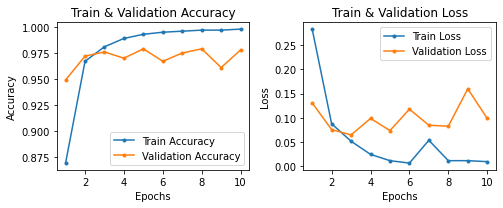

In [ ]:
epochs=[1,2,3,4,5,6,7,8,9,10]
train_acc=[.869,.967,.981,.989,.993,.995,.996,.997,.997,.998]
train_loss=[0.283,0.088,0.052,0.025,0.012,0.007,0.054,0.012,0.012,0.010]
val_acc=[0.949,.972,.976,.970,.979,.967,.975,.979,.961,.978]
val_loss=[0.131,0.076,0.065,0.099,0.074,0.118,0.085,0.083,0.160,0.099]

fig , ax = plt.subplots(1,2, figsize=(7,3))
ax[0].plot(epochs , train_acc , '.-' , label = 'Train Accuracy')
ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
ax[0].set_title('Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[1].plot(epochs , train_loss , '.-' , label = 'Train Loss')
ax[1].plot(epochs , val_loss , '.-' , label = 'Validation Loss')
ax[1].set_title('Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
fig.tight_layout()
fig.show()

                